In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),    # 将图像数据从 PIL 图像格式转换为 PyTorch 张量（Tensor）
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   # 对图像的每个通道进行标准化处理，均值为 0.5，标准差为 0.5,并将其值归一化到 [0, 1] 范围
    ])

cifar10_train = datasets.CIFAR10(root='./dataset', train=True, download=False, transform=transform)
cifar10_test = datasets.CIFAR10(root='./dataset', train=False, download=False, transform=transform)

In [3]:
# 设置随机种子,使训练结果可以复现
# 在需要生成随机数据的实验中,每次实验都需要生成数据。设置随机种子是为了确保每次生成固定的随机数,这就使得每次实验结果显示一致了,有利于实验的比较和改进。使得每次运行该 .py 文件时生成的随机数相同。
def same_seed(seed):
    random.seed(seed) # 给random库设置随机种子
    np.random.seed(seed) # 保证后续使用random函数时,产生固定的随机数
    torch.manual_seed(seed) # 为CPU设置随机种子用于生成随机数,使得结果准确,方便下次复现,随机种子作用域是在设置时到下一次设置时
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为特定的GPU设备设置相同的随机种子
        torch.cuda.manual_seed_all(seed) # 为所有可用的GPU设备设置相同的随机种子
    torch.backends.cudnn.benchmark = False # 禁用自动优化,保证每次运行时使用相同算法
    torch.backends.cudnn.deterministic = True # 固定网络结构,固定随机输入之后再固定网络结构,保证模型每次运行都能得到同样的结果,保证模型的可复现性
same_seed(39)

In [5]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(dataset=cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=cifar10_test, batch_size=batch_size, shuffle=False)

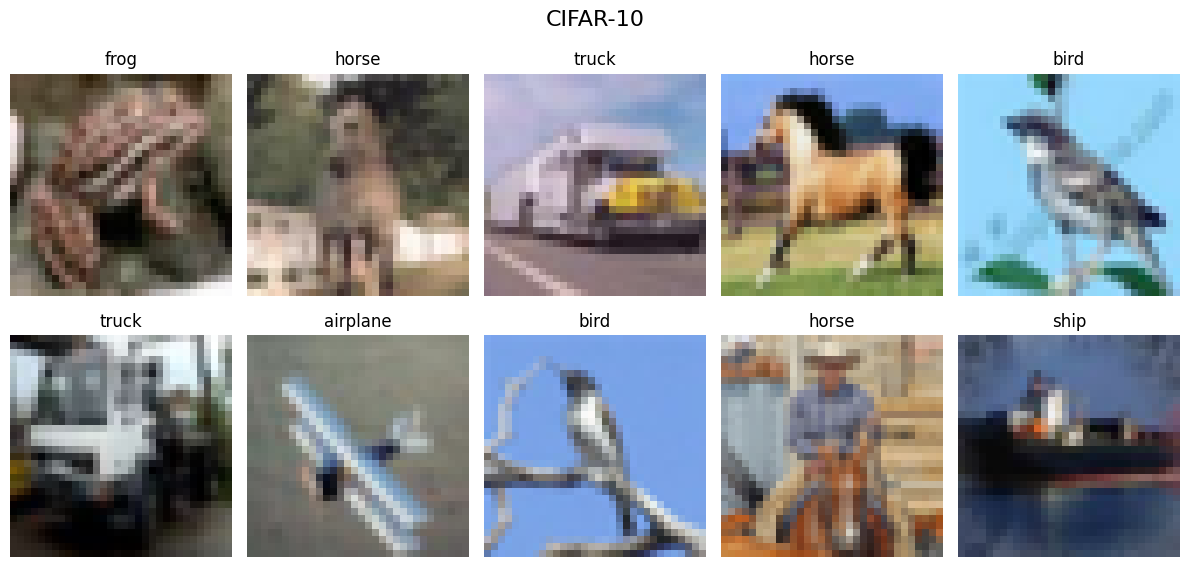

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(12, 6))
for i in range(10):
    img = (images[i] * 0.5 + 0.5)  # 反归一化
    img = img.permute(1, 2, 0).numpy()  # CHW -> HWC

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis('off')

plt.suptitle("CIFAR-10", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6,5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

# 模型实例化与设备部署
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CIFAR10_CNN().to(device)

# 使用 torchinfo 输出模型摘要
from torchinfo import summary
summary(model, (64, 3, 32, 32))  


Layer (type:depth-idx)                   Output Shape              Param #
CIFAR10_CNN                              [64, 10]                  --
├─Sequential: 1-1                        [64, 6, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           456
│    └─ReLU: 2-2                         [64, 6, 28, 28]           --
│    └─MaxPool2d: 2-3                    [64, 6, 14, 14]           --
├─Sequential: 1-2                        [64, 16, 5, 5]            --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─ReLU: 2-5                         [64, 16, 10, 10]          --
│    └─MaxPool2d: 2-6                    [64, 16, 5, 5]            --
├─Sequential: 1-3                        [64, 10]                  --
│    └─Flatten: 2-7                      [64, 400]                 --
│    └─Linear: 2-8                       [64, 120]                 48,120
│    └─ReLU: 2-9                         [64, 120]                 --
│    └─

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:

def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    for i in range(epoch):
        running_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    i, batch_idx * len(inputs), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), running_loss / 100))
                running_loss = 0.0
        if i % 10 == 0:
            torch.save(model.state_dict(), './checkpoints/model_{}.pth'.format(i))
            print('Model saved as model_{}.pth'.format(i))

train(model, train_loader, criterion, optimizer, 100)

Train Epoch: 0 [0/50000 (0%)]	Loss: 0.023098
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.302992
Model saved as model_0.pth
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.023055
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.300810
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.022932
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.296714
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.022943
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.288094
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.022705
Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.263945
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.022452
Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.211651
Train Epoch: 6 [0/50000 (0%)]	Loss: 0.021739
Train Epoch: 6 [25600/50000 (51%)]	Loss: 2.123078
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.019883
Train Epoch: 7 [25600/50000 (51%)]	Loss: 2.010069
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.019494
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.927956
Train Epoch: 9 [0/50000 (0%)]	Loss: 0.019336
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.880062
Train Epoch: 10 [0/5000

              precision    recall  f1-score   support

       plane       0.67      0.70      0.69      1000
         car       0.72      0.76      0.74      1000
        bird       0.60      0.45      0.52      1000
         cat       0.42      0.46      0.44      1000
        deer       0.62      0.44      0.52      1000
         dog       0.55      0.48      0.51      1000
        frog       0.60      0.81      0.69      1000
       horse       0.70      0.69      0.70      1000
        ship       0.70      0.79      0.74      1000
       truck       0.68      0.69      0.68      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.62     10000
weighted avg       0.63      0.63      0.62     10000



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FEB57E1700>
Traceback (most recent call last):
  File "D:\Python\Python39\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "D:\Python\Python39\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


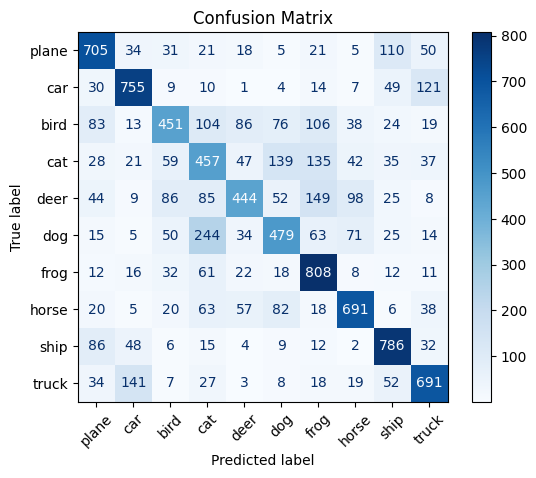

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1) 在 test 函数里收集
y_trues, y_preds = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu()
        y_preds.extend(preds.numpy())
        y_trues.extend(y.numpy())

# 2) 计算并打印报告
print(classification_report(y_trues, y_preds, target_names=classes))

# 3) 混淆矩阵
cm = confusion_matrix(y_trues, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()


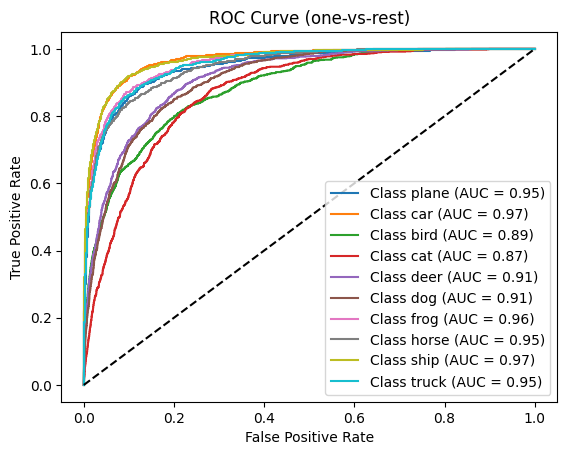

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 假设有 10 类
n_classes = 10
y_trues_bin = label_binarize(y_trues, classes=list(range(n_classes)))
y_scores    = []  # 用 softmax 后的概率

model.eval()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        logits = model(x)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        y_scores.append(probs)
y_scores = np.vstack(y_scores)

# 针对每一类画 ROC
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_trues_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (one-vs-rest)')
plt.legend(loc='lower right')
plt.show()


In [ ]:

def test(model, test_loader):
    model.eval()
    class_correct = list(0. for _ in range(10))
    class_total = list(0. for _ in range(10))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(images)):
                label = labels[i].item()  # 转换为 Python 整数
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
    for i in range(10):
        if class_total[i] > 0:
            print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i]/class_total[i]:2.0f}%')
        else:
            print(f'Accuracy of {classes[i]:5s} : N/A')
test(model, test_loader)

Accuracy of plane : 70%
Accuracy of car   : 76%
Accuracy of bird  : 45%
Accuracy of cat   : 46%
Accuracy of deer  : 44%
Accuracy of dog   : 48%
Accuracy of frog  : 81%
Accuracy of horse : 69%
Accuracy of ship  : 79%
Accuracy of truck : 69%
